# [VGG11]

*KU LeeDongGyu*

### Contents

1. Data Preprocessing
```
1) Data Import
2) Data Augmentation
```
2. Support Functions

3. Almost Original VGG11
```
1) Almost Original VGG11
2) VGG11 Evaluate
```



### Install Packages

### Module

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [3]:
from f1score import macro_f1score,weighted_f1score

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Paper'

In [6]:
print(tf.__version__)
print(ks.__version__)

2.3.0
2.4.0


In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1365747086316562597
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10679350583701610803
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11334311631026339670
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15473775744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7898609673817438488
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


## 1. Data Preprocessing
---

### 1) Data Import

In [9]:
# 바꿔서 살펴 볼 것들
# CALTECH, CIFAR100, FER, MIT
data_name = 'CIFAR100'
gan_type = 'No_GAN'
number = '1'
size = 224 # sizes after cropping
super_size = 256 # sizes before cropping 
input_sizes = (size,size,3)
batch_sizes = 128
weight_decay = 1e-4
epochs = 70

In [10]:
# 참고 : https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216
# setting the seed number for random number generation for reproducibility.

from numpy.random import seed
import random


if number=='1':
    seed_num = 200225
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='2':
    seed_num = 727
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='3':
    seed_num = 115
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='4':
    seed_num = 501
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='5':
    seed_num = 517
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [11]:
# data import

if data_name=='FER' :
    x_train =  np.zeros(28698)
    x_valid = np.zeros(3589)
    x_test = np.zeros(3588)
    classes = 7 
    tr_center = [0.50793296, 0.50793296, 0.50793296]
elif data_name=='MIT':
    x_train = np.zeros(12466)
    x_valid = np.zeros(1564)
    x_test = np.zeros(1590)
    classes = 67 
    tr_center = [0.47916578, 0.42029615, 0.36046057]
elif data_name=='CALTECH':
    x_train = np.zeros(24510)
    x_valid = np.zeros(2980)
    x_test = np.zeros(3118)
    classes = 257
    tr_center = [0.51397761, 0.49525248, 0.46555727]
elif data_name=='CIFAR100':
    x_train = np.zeros(44923)
    x_valid = np.zeros(5077)
    x_test = np.zeros(10000)
    classes = 100
    tr_center = [0.53442983, 0.51355958, 0.46462564]

In [12]:
dir = os.path.join(os.getcwd(),data_name,gan_type)

### 2) Data Augmentation

In [13]:
# 참고 : https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3 # img.shape[2] 가 3(rgb)이 아니면 assertion error 발생
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import glob

# 데이터 전체에 대해 centering 진행함.

def read_cal_image(img_path): 
    x = img_to_array(load_img(img_path)) # x는 채널별 평균값
    y = x.shape[0] * x.shape[1]# y는 데이터별 픽셀 수 (비중)

    x = 1/255. * x # scaling하고, centering값을 뽑아냄.
    x = np.mean(x, axis=(0,1))
    
    return np.hstack([x,y])

def calculate_centered_mean(dataset_path,x_train=x_train):
    num = len(x_train)
    space = np.empty((num,4))
    i=0

    for p in glob.glob(os.path.join(dataset_path,'*/*.*')) :
        space[i] = read_cal_image(p)
        i += 1

    ratio = space[:,3] / np.sum(space[:,3])

    return np.average(space[:,0:3],axis=0,weights=ratio)


# 아래의 함수를 돌려서 나온 결과값을 중심화 값으로 설정.

# train_mean = calculate_centered_mean(os.path.join(dir,'data/train')).reshape((1,1,3))

In [15]:
datagen_tr = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.9,1.0],
    fill_mode = 'nearest')
datagen_val = ImageDataGenerator(rescale=1/255.,featurewise_center=True)
datagen_tes = ImageDataGenerator(rescale=1/255.,featurewise_center=True)

# 원래는 이 자리에 fit 매서드를 써야하지만, 그냥 내가 중심화함수를 만들고 적용함. 

# 중심화 설정
datagen_tr.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_val.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_tes.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB

In [16]:
train_batches = datagen_tr.flow_from_directory(directory=os.path.join(dir,'data/train'),target_size=(super_size,super_size),batch_size=batch_sizes,class_mode='categorical') # fer : 28698 / mit : 12466 / caltech : 24509 / cifar : 44923
train_generator= crop_generator(train_batches, size)
valid_generator = datagen_val.flow_from_directory(directory=os.path.join(dir,'data/valid'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3589 / mit : 1564 / caltech : 2980 / cifar : 5077
test_generator = datagen_tes.flow_from_directory(directory=os.path.join(dir,'data/test'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3588 / mit : 1590 / caltech : 3118 / cifar : 10000

Found 44923 images belonging to 100 classes.
Found 5077 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.


## 2. Support Functions
---

In [ ]:
# def lr_schedule(epoch):
#     init_lr = 1e-4
#     k = 0.04
#     lr = init_lr * np.exp(-k*epoch)
#     print('Learning rate: ', lr)
#     return lr

def lr_schedule(epoch):
    lr = 3e-4
    if epoch < 30:
        lr = lr
    elif epoch < 60 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

## 3. Almost Original VGG11
---

### 1) Almost Original VGG11

In [ ]:
# VGG11를 최대한 논문에 가깝게 맞춰 모형작성.

def VGG11(input_shape=(224, 224, 3), classes=1000, weight_decay=weight_decay, name='VGG11'):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    output = Dense(classes, activation='softmax', kernel_regularizer=l2(weight_decay), name='predictions')(x)

    # Create model.
    model = Model(img_input, output, name=name)

    return model

In [ ]:
model = VGG11(input_shape=input_sizes, classes=classes, name='VGG11')

In [ ]:
model.summary()

Model: "VGG11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 56, 56, 256)       590080

In [ ]:
# 폴더 생성

os.makedirs(os.path.join(dir,'model_output',number,model.name), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [ ]:
# 참고 : https://github.com/OverLordGoldDragon/keras-adamw

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW, NadamW, SGDW

In [ ]:
# top-5 accuracy 출력
import functools
top5_acc = functools.partial(ks.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

In [ ]:
#optimizer = SGDW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes, nesterov=True, momentum=0.9)
optimizer = AdamW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes)
#optimizer = Adam()
filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')

callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  #ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,min_lr=1e-5),
                  LearningRateScheduler(lr_schedule,verbose=1)
                  ]
                  
model.compile(optimizer, loss = 'categorical_crossentropy', metrics=['accuracy',top5_acc,macro_f1score])

In [ ]:
######## flow_from_directory
history = model.fit(train_generator, steps_per_epoch=int(len(x_train)/batch_sizes),  validation_data = valid_generator, epochs=epochs , verbose=1 , callbacks = callbacks_list , validation_steps=int(len(x_valid)/batch_sizes))

Learning rate:  0.0003

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 1/70
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block1_conv1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block2_conv1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block3_conv1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block3_conv2/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block4_conv1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block4_conv2/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block5_conv1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for block5_conv2/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for fc1/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for fc2/kernel:0
0.0(L1), 5.34522470321675e-06(L2) weight decay set for predictions/kernel:0
350/350 [==============================] - ETA: 0s - loss: 4.1791 - 

### 2) VGG11 Evaluate


In [ ]:
# 1. epoch=maximum
loss , acc, top5_acc, mf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Top-1 Accuracy: %.4f / Test Top-5 Accuracy: %.4f / Test Macro f1: %.4f]\n' % (loss,acc,top5_acc,mf1))

78/78 [==============================] - 3152s 40s/step - loss: 1.5273 - accuracy: 0.6673 - top5_acc: 0.8866 - macro_f1score: 0.4599
[Test Loss: 1.5273 /  Test Top-1 Accuracy: 0.6673 / Test Top-5 Accuracy: 0.8866 / Test Macro f1: 0.4599]



In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
top5_acc=history.history['top5_acc']
val_top5_acc=history.history['val_top5_acc']
f1=history.history['macro_f1score']
val_f1=history.history['val_macro_f1score']
epochs=range(1,len(acc)+1)

data = np.array([epochs,loss,val_loss,acc,val_acc,top5_acc,val_top5_acc,f1,val_f1]).T

In [ ]:
# data save
# epochs, loss, val_loss, acc, val_acc, top5_acc, val_top5_acc, f1, val_f1

np.savetxt(os.path.join(dir,'train_valid_output',number,model.name+'.txt'),data)

In [ ]:
# data import
data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'VGG11.txt'))

In [ ]:
epochs=data[:,0]
loss=data[:,1]
val_loss=data[:,2]
acc=data[:,3]
val_acc=data[:,4]
top5_acc=data[:,5]
val_top5_acc=data[:,6]

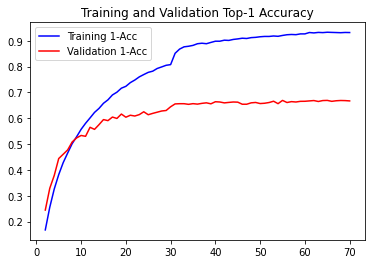

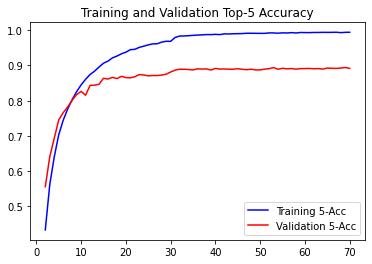

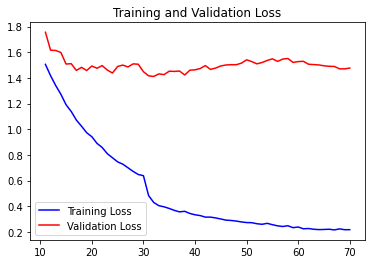

In [ ]:
plt.plot(epochs[1:],acc[1:],'b',label='Training 1-Acc')
plt.plot(epochs[1:],val_acc[1:],'r',label='Validation 1-Acc')
plt.title('Training and Validation Top-1 Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs[1:],top5_acc[1:],'b',label='Training 5-Acc')
plt.plot(epochs[1:],val_top5_acc[1:],'r',label='Validation 5-Acc')
plt.title('Training and Validation Top-5 Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs[10:],loss[10:],'b',label='Training Loss')
plt.plot(epochs[10:],val_loss[10:],'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
# 이 아래는 내가 인위적으로 살펴보고 싶은 epoch에 대해서 결과값 출력 / VGG11

In [18]:
# 참고 : https://github.com/OverLordGoldDragon/keras-adamw

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW, NadamW, SGDW

In [19]:
# top-5 accuracy 출력
import functools
top5_acc = functools.partial(ks.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

In [21]:
model=load_model(os.path.join(dir,'model_output',number,'VGG11','055.h5'),custom_objects={"macro_f1score": macro_f1score,"top5_acc":top5_acc, "AdamW":AdamW})

In [22]:
# 2. epoch=?
loss , acc, top5_acc, mf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Top-1 Accuracy: %.4f / Test Top-5 Accuracy: %.4f / Test Macro f1: %.4f]\n' % (loss,acc,top5_acc,mf1))

78/78 [==============================] - 5084s 65s/step - loss: 1.5776 - accuracy: 0.6630 - top5_acc: 0.8854 - macro_f1score: 0.4508
[Test Loss: 1.5776 /  Test Top-1 Accuracy: 0.6630 / Test Top-5 Accuracy: 0.8854 / Test Macro f1: 0.4508]

